In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
import os

# Path where your dataset is stored
data_dir = r"C:\Users\Palash\Downloads\chest-xray-pneumonia\chest_xray"

# Train / Val / Test directories
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "val")
test_dir  = os.path.join(data_dir, "test")

print("Train:", train_dir)
print("Val:", val_dir)
print("Test:", test_dir)

Train: C:\Users\Palash\Downloads\chest-xray-pneumonia\chest_xray\train
Val: C:\Users\Palash\Downloads\chest-xray-pneumonia\chest_xray\val
Test: C:\Users\Palash\Downloads\chest-xray-pneumonia\chest_xray\test


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", color_mode="rgb"   # 👈 force RGB
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", color_mode="rgb"
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", shuffle=False, color_mode="rgb"
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
def create_densenet(dense_units=128, dropout_rate=0.5, lr=1e-4):
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE,3))
    base_model.trainable = False  # freeze pretrained layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(optimizer=Adam(lr), loss="binary_crossentropy", metrics=["accuracy"])
    return model

densenet_model = create_densenet()


In [5]:
history_frozen = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,   # increase later to 10 with fine tuning
    verbose=2
)

C:\Users\Palash\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 - 1151s - 7s/step - accuracy: 0.7998 - loss: 0.4311 - val_accuracy: 0.6875 - val_loss: 0.5381
Epoch 2/5
163/163 - 1087s - 7s/step - accuracy: 0.9011 - loss: 0.2564 - val_accuracy: 0.8125 - val_loss: 0.4602
Epoch 3/5
163/163 - 1118s - 7s/step - accuracy: 0.9143 - loss: 0.2169 - val_accuracy: 0.6875 - val_loss: 0.5063
Epoch 4/5
163/163 - 1141s - 7s/step - accuracy: 0.9296 - loss: 0.1846 - val_accuracy: 0.8125 - val_loss: 0.3906
Epoch 5/5
163/163 - 1088s - 7s/step - accuracy: 0.9312 - loss: 0.1785 - val_accuracy: 0.8125 - val_loss: 0.3807


20/20 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step 
              precision    recall  f1-score   support

      NORMAL       0.91      0.65      0.76       234
   PNEUMONIA       0.82      0.96      0.89       390

    accuracy                           0.84       624
   macro avg       0.86      0.81      0.82       624
weighted avg       0.85      0.84      0.84       624

F1-score: 0.8852071005917159


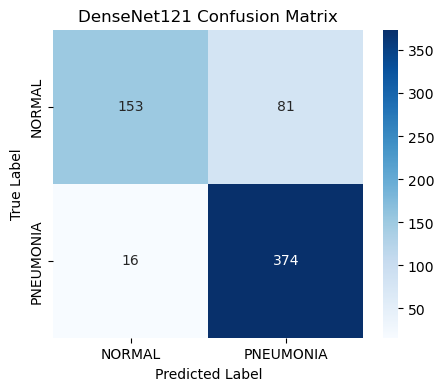

In [6]:
y_pred = densenet_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=["NORMAL","PNEUMONIA"]))
print("F1-score:", f1_score(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL","PNEUMONIA"], yticklabels=["NORMAL","PNEUMONIA"])
plt.title("DenseNet121 Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

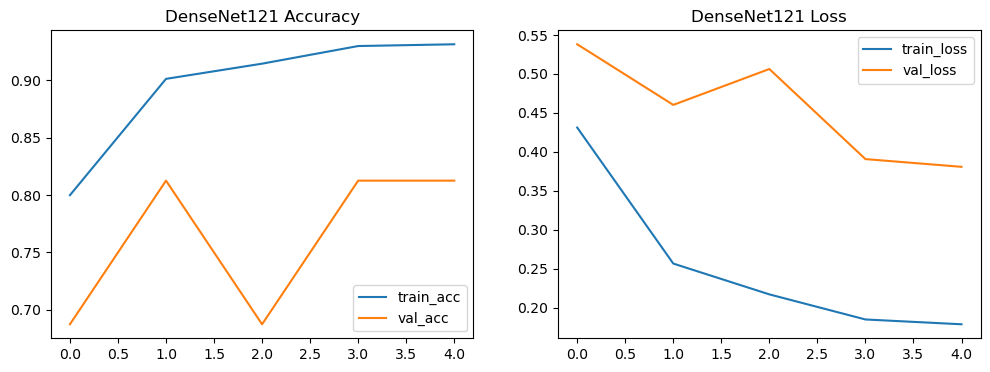

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_frozen.history["accuracy"], label="train_acc")
plt.plot(history_frozen.history["val_accuracy"], label="val_acc")
plt.title("DenseNet121 Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_frozen.history["loss"], label="train_loss")
plt.plot(history_frozen.history["val_loss"], label="val_loss")
plt.title("DenseNet121 Loss")
plt.legend()

plt.show()

In [8]:
# Unfreezing  the base model
densenet_model.layers[0].trainable = True  

# Freeze all layers except the last 50
for layer in densenet_model.layers[0].layers[:-50]:
    layer.trainable = False

In [9]:
from tensorflow.keras.optimizers import Adam

densenet_model.compile(
    optimizer=Adam(1e-5),   # smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_densenet_finetuned.h5", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

history_finetune = densenet_model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=5,    # continue from epoch 5
    epochs=10,          # train till epoch 10
    callbacks=[early_stop, checkpoint],
    verbose=2
)

Epoch 6/10

Epoch 6: val_accuracy improved from None to 0.81250, saving model to best_densenet_finetuned.h5


163/163 - 1140s - 7s/step - accuracy: 0.9346 - loss: 0.1659 - val_accuracy: 0.8125 - val_loss: 0.3905
Epoch 7/10

Epoch 7: val_accuracy did not improve from 0.81250
163/163 - 1132s - 7s/step - accuracy: 0.9436 - loss: 0.1445 - val_accuracy: 0.8125 - val_loss: 0.3573
Epoch 8/10

Epoch 8: val_accuracy improved from 0.81250 to 0.87500, saving model to best_densenet_finetuned.h5


163/163 - 1167s - 7s/step - accuracy: 0.9511 - loss: 0.1313 - val_accuracy: 0.8750 - val_loss: 0.3111
Epoch 9/10

Epoch 9: val_accuracy did not improve from 0.87500
163/163 - 1190s - 7s/step - accuracy: 0.9498 - loss: 0.1318 - val_accuracy: 0.8750 - val_loss: 0.2832
Epoch 10/10

Epoch 10: val_accuracy did not improve from 0.87500
163/163 - 1321s - 8s/step - accuracy: 0.9538 - loss: 0.1263 - val_accuracy: 0.8750 - val_loss: 0.2487


In [12]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Predict probabilities
y_prob = densenet_model.predict(test_generator)
y_pred = (y_prob > 0.5).astype(int)

# True labels
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=["NORMAL","PNEUMONIA"]))

# Just F1-score
print("F1-score:", f1_score(y_true, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 147s 7s/step 
              precision    recall  f1-score   support

      NORMAL       0.95      0.68      0.79       234
   PNEUMONIA       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624

F1-score: 0.9020070838252656


In [14]:
# Combine histories
def combine_histories(history_frozen, history_finetune):
    acc = history_frozen.history['accuracy'] + history_finetune.history['accuracy']
    val_acc = history_frozen.history['val_accuracy'] + history_finetune.history['val_accuracy']
    loss = history_frozen.history['loss'] + history_finetune.history['loss']
    val_loss = history_frozen.history['val_loss'] + history_finetune.history['val_loss']
    return acc, val_acc, loss, val_loss

acc, val_acc, loss, val_loss = combine_histories(history_frozen, history_finetune)

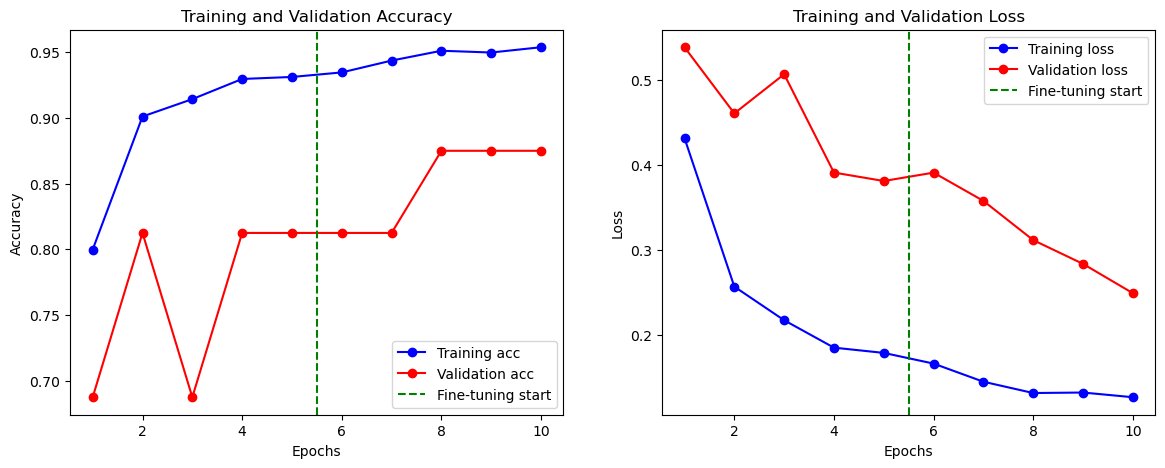

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.axvline(x=5.5, color='g', linestyle='--', label='Fine-tuning start')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.axvline(x=5.5, color='g', linestyle='--', label='Fine-tuning start')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
densenet_model.save("densenet_pneumonia.h5")

In [19]:
test_loss, test_acc = densenet_model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 114s 6s/step - accuracy: 0.8670 - loss: 0.3492
Test Accuracy: 86.70%
Test Loss: 0.3492
